<a href="https://colab.research.google.com/github/Jgmedina95/molbloom-paper/blob/main/molbloom_fpr_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install molbloom


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 29.4 MB/s eta 0:00:00


In [ ]:
pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 39.2 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import FuncFormatter
import numpy as np
import math
import os
import urllib
from dataclasses import dataclass
import json
import sys
from molbloom import CustomFilter, canon
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, AllChem, MACCSkeys, rdMolDescriptors
import time
from urllib.request import urlopen
from urllib.error import URLError, HTTPError
import json
#np.random.seed(0)
urllib.request.urlretrieve('https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf', 'IBMPlexMono-Regular.ttf')
fe = font_manager.FontEntry(
    fname='IBMPlexMono-Regular.ttf',
    name='plexmono')
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update({'axes.facecolor':'#f5f4e9', 
            'grid.color' : '#AAAAAA', 
            'axes.edgecolor':'#333333', 
            'figure.facecolor':'#FFFFFF', 
            'axes.grid': False,
            'axes.prop_cycle':   plt.cycler('color', plt.cm.Dark2.colors),
            'font.family': fe.name,
            'figure.figsize': (3.5,3.5 / 1.2),
            'ytick.left': True,
            'xtick.bottom': True   
           })

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open("/content/drive/MyDrive/COCONUT_DB.smi", "r") as f:
    smi_list = f.readlines()
#smi_list

In [ ]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.warning') #this is for cleaner presentation. A lot of messages of the type: [13:19:48] Explicit valence for atom # 3 B, 4, is greater than permitted

In [ ]:
mols = []
can_smiles = []
for i,smi in enumerate(smi_list):
  mol = Chem.MolFromSmiles(smi.split(" ")[0])
  if mol:
    mols.append(mol)
    can_smiles.append(Chem.MolToSmiles(mol,True))

In [ ]:
#this takes some minutes
third_fps = [rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol) for mol in mols]
morgan_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2) for mol in mols]
rdkfingerprints = [Chem.RDKFingerprint(mol) for mol in mols]
MACCfps = [MACCSkeys.GenMACCSKeys(mol)for mol in mols]

In [ ]:
#python implementation of bloom filter with fps

def create_empty_bloom_filter(size):
    return np.zeros(size)

def hashed_indexes(h1,h2,size):
  indexes = []
  for i in range(max(8, min(64, int(size / int(406919/2) * math.log(2))))):
     indexes.append(((h1) + i*(h2))%size)
  return indexes

def add_molecules(fp1,fp2,bf,size):
  h1 = int(DataStructs.BitVectToText(fp1),base=2)
  h2 = int(DataStructs.BitVectToText(fp2),base=2)
  for index in hashed_indexes(h1,h2,size):
    bf[index]=1
  return bf
  
def check_molecule(fp1, fp2, bf, size):
    h1 = int(DataStructs.BitVectToText(fp1), base=2)
    h2 = int(DataStructs.BitVectToText(fp2), base=2)
    for index in hashed_indexes(h1, h2, size):
        if bf[index] == 0:
            return False
    return True


In [ ]:
#setting parameters for tests
bloom_size = [10,100,1000,10000,50000,100000,150000,200000,250000,300000,350000,400000,450000,
             500000,550000,600000,650000,700000,750000,800000,850000,900000,950000,1000000,2000000,
              3000000,4000000,5000000,10_000_000,100_000_000]
split = int(len(mols)/2)
fpr_fps = []
is_in_fps = []
def test_wraper(fps1,fps2,size_range,split_index):
  fpr_fps=[]
  for size in size_range:
    is_not_fps = []
    bf = create_empty_bloom_filter(size)
    for i, (fp1,fp2) in enumerate(zip(fps1,fps2)):
      if i <split_index:
        bf = add_molecules(fp1,fp2,bf,size)
      else:
        is_not_fps.append(check_molecule(fp1,fp2,bf,size))
    print(f'false positive rate fps:size {size:1.2E} {100-((len(is_not_fps)-sum(is_not_fps))*100/len(is_not_fps))}')
    fpr_fps.append(100-((len(is_not_fps)-sum(is_not_fps))*100/len(is_not_fps)))
  return fpr_fps


In [ ]:
##This takes a while, 31 different filter sizes for each test.
#print("morgan_fps", "atom_pair_fingerprints")
fpr_fps1 = test_wraper(morgan_fps,third_fps,bloom_size,split)
#print("morgan_fps", "rdkfingerprints")
fpr_fps2 = test_wraper(morgan_fps,rdkfingerprints,bloom_size,split)
#print("morgan_fps","MACCS")
fpr_fps3 = test_wraper(morgan_fps,MACCfps,bloom_size,split)
#print("atom_pair_fingerprints", "RDK_fingerprints")
fpr_fps4 = test_wraper(third_fps,rdkfingerprints,bloom_size,split)
#print("atom_pair_fingerprints", "MACCfps")
fpr_fps5 = test_wraper(third_fps,MACCfps,bloom_size,split)
#print("rdk_fingerprints","MACCS")
fpr_fps6 = test_wraper(rdkfingerprints,MACCfps,bloom_size,split)

false positive rate fps:size 1.00E+01 100.0
false positive rate fps:size 1.00E+02 100.0
false positive rate fps:size 1.00E+03 100.0
false positive rate fps:size 1.00E+04 99.61319178216849
false positive rate fps:size 5.00E+04 97.84773419836823
false positive rate fps:size 1.00E+05 96.7394082374914
false positive rate fps:size 1.50E+05 95.179396441561
false positive rate fps:size 2.00E+05 94.64022412267768
false positive rate fps:size 2.50E+05 93.30777548412465
false positive rate fps:size 3.00E+05 92.1832301189423
false positive rate fps:size 3.50E+05 91.86375700383368
false positive rate fps:size 4.00E+05 90.60552442740588
false positive rate fps:size 4.50E+05 90.4855991349651
false positive rate fps:size 5.00E+05 88.93492578393787
false positive rate fps:size 5.50E+05 89.36695173498477
false positive rate fps:size 6.00E+05 87.37098201120614
false positive rate fps:size 6.50E+05 88.30286051312297
false positive rate fps:size 7.00E+05 86.46515285559815
false positive rate fps:size 7.50

In [ ]:
fpr_smi = []
for size in bloom_size:
  bloom_smi = CustomFilter(size,200000,"myfilter")
  is_not_smiles = []
  for i,smi in enumerate(can_smiles):
    if i <split:
        bloom_smi.add(smi)
    if i > split:       
      is_not_smiles.append(bloom_smi.__contains__(smi))
  fpr_smi.append(100-(len(is_not_smiles)-sum(is_not_smiles))*100/len(is_not_smiles))
  print(size,len(is_not_smiles))
  print(f'false positive rate smiles: {100-(len(is_not_smiles)-sum(is_not_smiles))*100/len(is_not_smiles)}')

10 203459
false positive rate smiles: 100.0
100 203459
false positive rate smiles: 100.0
1000 203459
false positive rate smiles: 100.0
10000 203459
false positive rate smiles: 100.0
50000 203459
false positive rate smiles: 100.0
100000 203459
false positive rate smiles: 100.0
150000 203459
false positive rate smiles: 99.99115300871429
200000 203459
false positive rate smiles: 99.76260573383335
250000 203459
false positive rate smiles: 98.7506082306509
300000 203459
false positive rate smiles: 96.61455133466694
350000 203459
false positive rate smiles: 92.47907440811171
400000 203459
false positive rate smiles: 87.26819654082641
450000 203459
false positive rate smiles: 80.355255850073
500000 203459
false positive rate smiles: 72.9252576686212
550000 203459
false positive rate smiles: 65.50410647845513
600000 203459
false positive rate smiles: 57.64208022255098
650000 203459
false positive rate smiles: 50.61658614266265
700000 203459
false positive rate smiles: 43.70462845094097
750000 

In [ ]:
def add_molecules_md(fp1,fp2,bf,size):

  for index in hashed_indexes(fp1,fp2,size):
    bf[index]=1
  return bf
  
def check_molecule_md(fp1, fp2, bf, size):

    for index in hashed_indexes(fp1, fp2, size):
        if bf[index] == 0:
            return False
    return True

def test_wraper_md(fps1,fps2,size_range,split_index):
    print()
    fpr_fps=[]
    for size in size_range:
        is_not_fps = []
        bf = create_empty_bloom_filter(size)
        for i, (fp1,fp2) in enumerate(zip(fps1,fps2)):
            if i < split_index:
                bf = add_molecules_md(fp1,fp2,bf,size)
            else:
                is_not_fps.append(check_molecule_md(fp1,fp2,bf,size))

        print(f'false positive rate fps:size {size:1.2E} {100-((len(is_not_fps)-sum(is_not_fps))*100/len(is_not_fps))}')
        fpr_fps.append(100-((len(is_not_fps)-sum(is_not_fps))*100/len(is_not_fps)))
    return fpr_fps

In [ ]:
import hashlib

In [ ]:
md4 = [int(hashlib.new("md4",smile.encode('utf-16le')).hexdigest(),16) for smile in can_smiles]
md5 = [int(hashlib.new("md5",smile.encode('utf-16le')).hexdigest(),16) for smile in can_smiles]
fpr_fpsmd = test_wraper_md(md4,md5,bloom_size,split)


false positive rate fps:size 1.00E+01 100.0
false positive rate fps:size 1.00E+02 100.0
false positive rate fps:size 1.00E+03 100.0
false positive rate fps:size 1.00E+04 100.0
false positive rate fps:size 5.00E+04 100.0
false positive rate fps:size 1.00E+05 100.0
false positive rate fps:size 1.50E+05 99.98328909859431
false positive rate fps:size 2.00E+05 99.79160522952914
false positive rate fps:size 2.50E+05 98.77224024378256
false positive rate fps:size 3.00E+05 96.35210852255972
false positive rate fps:size 3.50E+05 92.60051115698417
false positive rate fps:size 4.00E+05 87.25302270716602
false positive rate fps:size 4.50E+05 80.10714636783644
false positive rate fps:size 5.00E+05 72.96520200530817
false positive rate fps:size 5.50E+05 65.34306497591663
false positive rate fps:size 6.00E+05 57.81775287525804
false positive rate fps:size 6.50E+05 50.72151774304532
false positive rate fps:size 7.00E+05 43.919197876732525
false positive rate fps:size 7.50E+05 37.72387692912612
false 

In [ ]:
bloom_size = np.array(bloom_size)
import math

def bloom_filter_false_positive_rate(k, m, n):
    """
    Calculates the theoretical false positive rate of a Bloom filter
    with k hash functions and m bits in the filter, given the number
    of elements added to the filter.

    Args:
    - k (int): Number of hash functions
    - m (int): Number of bits in the filter
    - n (int): Number of elements added to the filter

    Returns:
    - Theoretical false positive rate of the Bloom filter
    """
    p = (1 - math.exp(-k * n / m)) ** k
    return p
theoretical_fpr = []
for size in bloom_size:
    theoretical_fpr.append(100*bloom_filter_false_positive_rate(max(8,min(64,size//(406919//2)*math.log(2))),size,int(406919/2)))

<ipython-input-19-6cdceb490954>:30: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  axs[i].get_shared_y_axes().join(axs[i], axs[i+3])


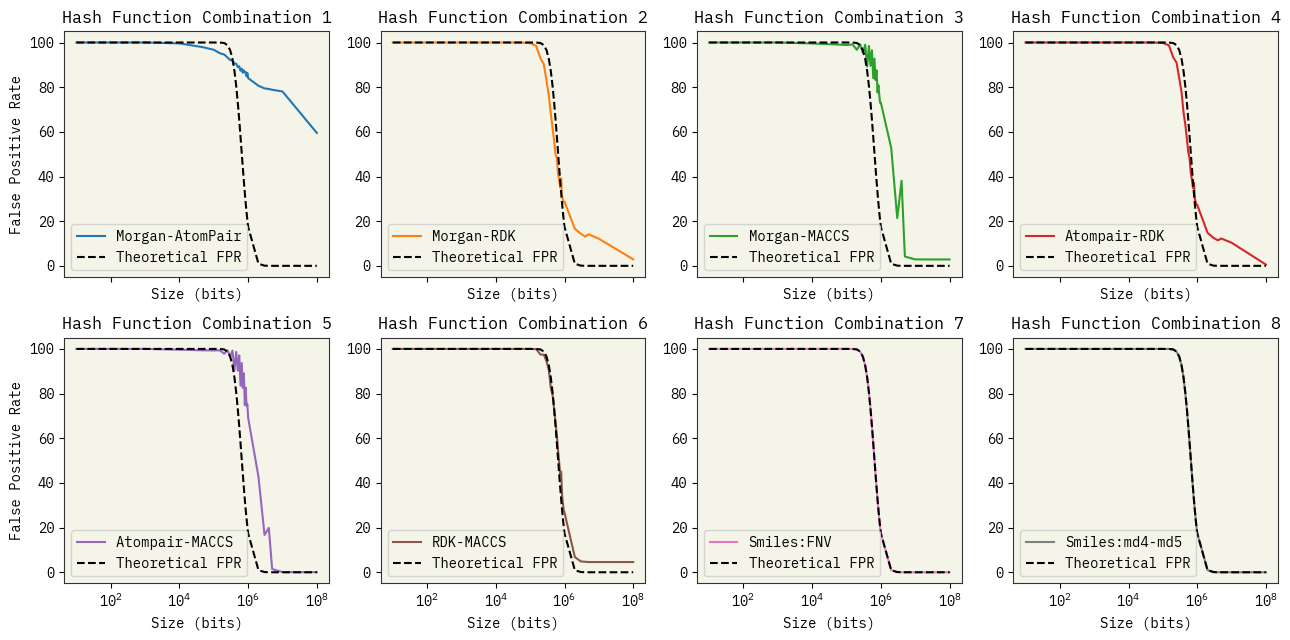

In [ ]:

# Define the data
data = {
    "Morgan-AtomPair": fpr_fps1,
    "Morgan-RDK": fpr_fps2,
    "Morgan-MACCS": fpr_fps3,
    "Atompair-RDK": fpr_fps4,
    "Atompair-MACCS ": fpr_fps5,
    "RDK-MACCS": fpr_fps6,
    "Smiles:FNV": fpr_smi,
    "Smiles:md4-md5": fpr_fpsmd
}

color_list = list(colors.TABLEAU_COLORS.values())
# Create the subplots
fig, axs = plt.subplots(2, 4, figsize=(13, 6.5), sharex=True, sharey=False)
axs = axs.flatten()

# Plot the data and theoretical values
for i, (name, values) in enumerate(data.items()):
    axs[i].plot(bloom_size, values, label=name,color=f'{color_list[i]}')
    axs[i].plot(bloom_size, theoretical_fpr, linestyle='--',color='black', label='Theoretical FPR')
    axs[i].set_xscale('log')
    axs[i].set_title(f"Hash Function Combination {i+1}")
    axs[i].set_xlabel("Size (bits)")
    axs[i].legend()

    # Set sharey to True for the first column
    if i % 4 == 0:
        axs[i].set_ylabel("False Positive Rate")
        axs[i].get_shared_y_axes().join(axs[i], axs[i+3])

# Remove y-axis for the remaining columns
#for i in range(1, 4):
#    for j in range(0, 2):
#        axs[i*4+j].get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()
